## Goal of the Notebook:
In this notebook we want to investigate whether it is useful to decompose the time series by statistical approaches and then use the decompositioned parts to make predictions. 

In [87]:
import numpy as np
import pandas as pd
import helper
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime, timedelta
import math

In [11]:
df = pd.read_csv("../data/raw/100014.csv", delimiter=";")
df = helper.update_timestamps(df)
df = df.set_index('published')
df.head()

### Upsample values to 5 min intervalls

First, we want to increase the time intervals by sampling the hourly data to 5 minute intervals and filling them with a moving average.

In [13]:
cat_cols = ["id", "id2", "title", "name"]

df = df.groupby(cat_cols).resample("60Min").nearest()
df = df.drop(columns=cat_cols).reset_index()
df = df.set_index('published')

df_intp = None
for title in set(df["title"]):
    sub_df = df.loc[df["title"]==title].copy()
    sub_df = sub_df.resample("5Min").interpolate(method="cubic")
    
    for col in cat_cols:
        sub_df[col] = df.loc[df["title"]==title][col].iat[0]
    
    if df_intp is not None:
        df_intp = pd.concat([df_intp, sub_df])
    else:
        df_intp = sub_df
df = df_intp

### Plot seasonal decomposition
Now we want to decompose the time series for the individual car parks in order to be able to reveal more about the trend and seasonalities of the individual number of free parking spots per car park. 

The decomposition is calculated using the method `seasonal_decompose` provided by statsmodels. It calculates the trend by using movig average. The seasonalities are caltulated using a per period average of the decentred series. From the previous data analysis, it is found that there is a strong daily, weekly and possibly even annual seasonal component in the data. Therefore, we focus on these three seasonalities for the decomposition.

For a good decomposition the residuals should be as small as possible. Which would mean, we have a lot of patterns that can be detected and modelled with statistical models.

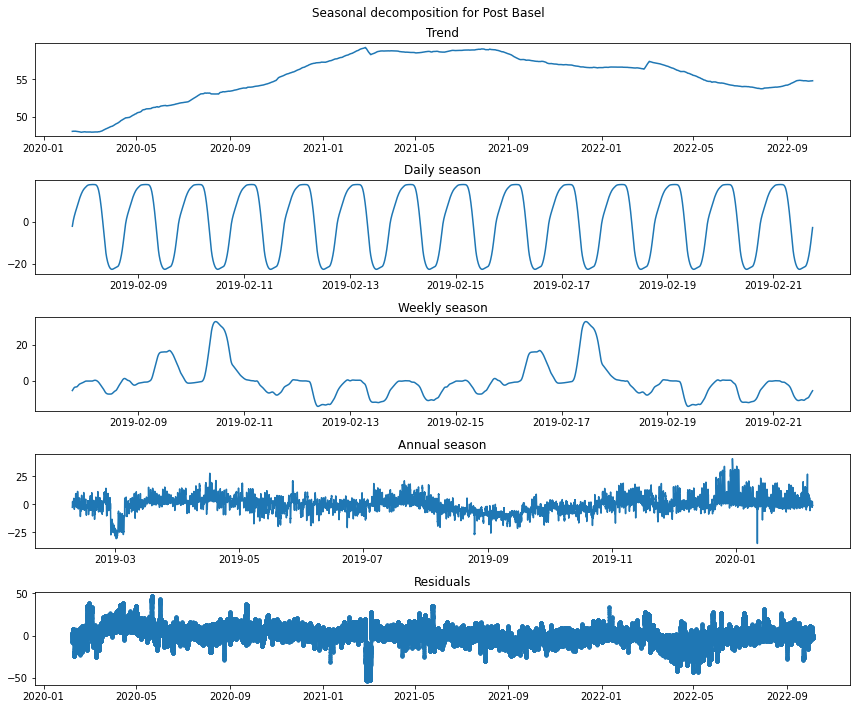

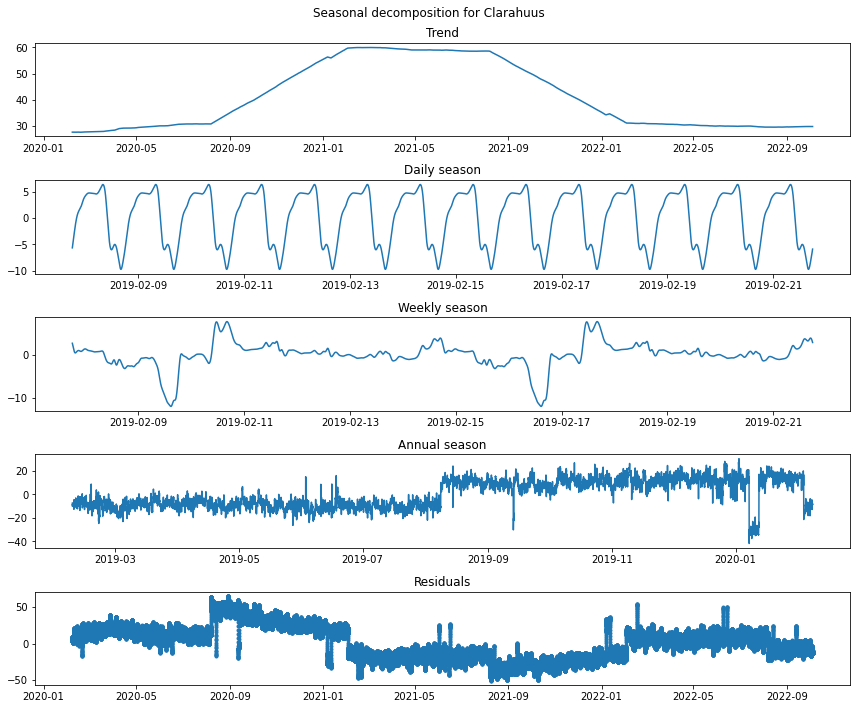

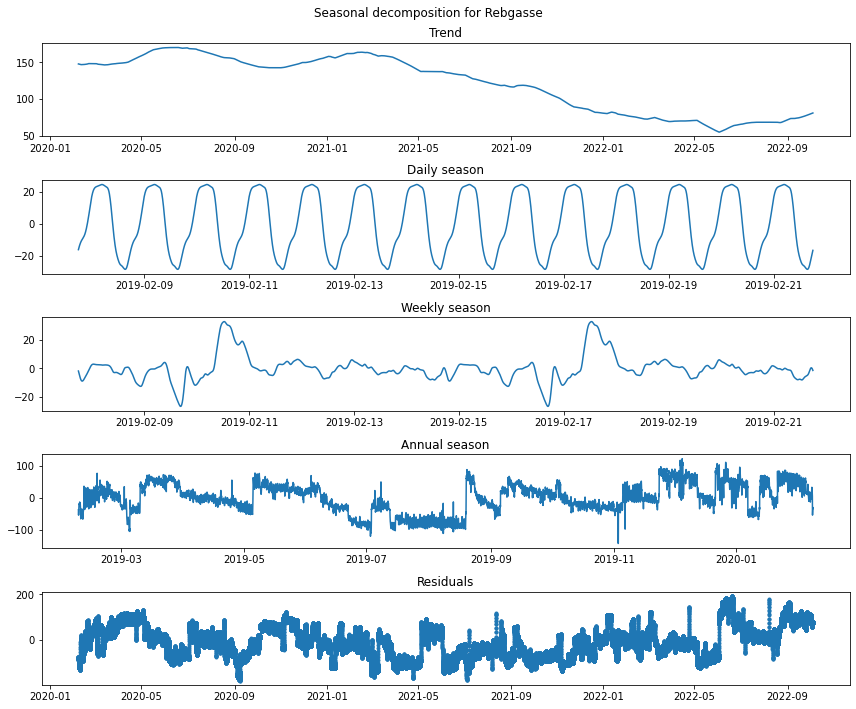

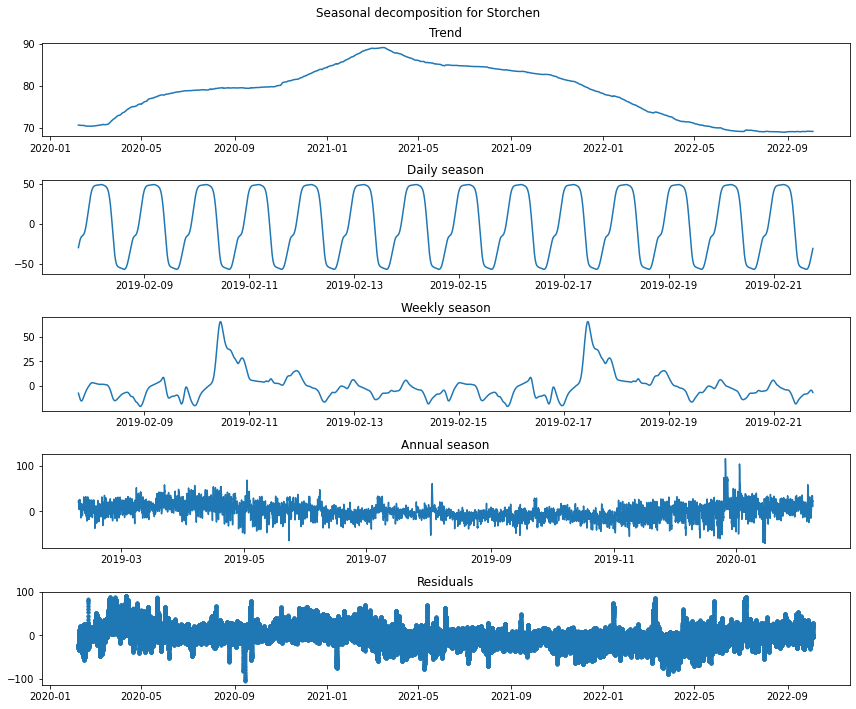

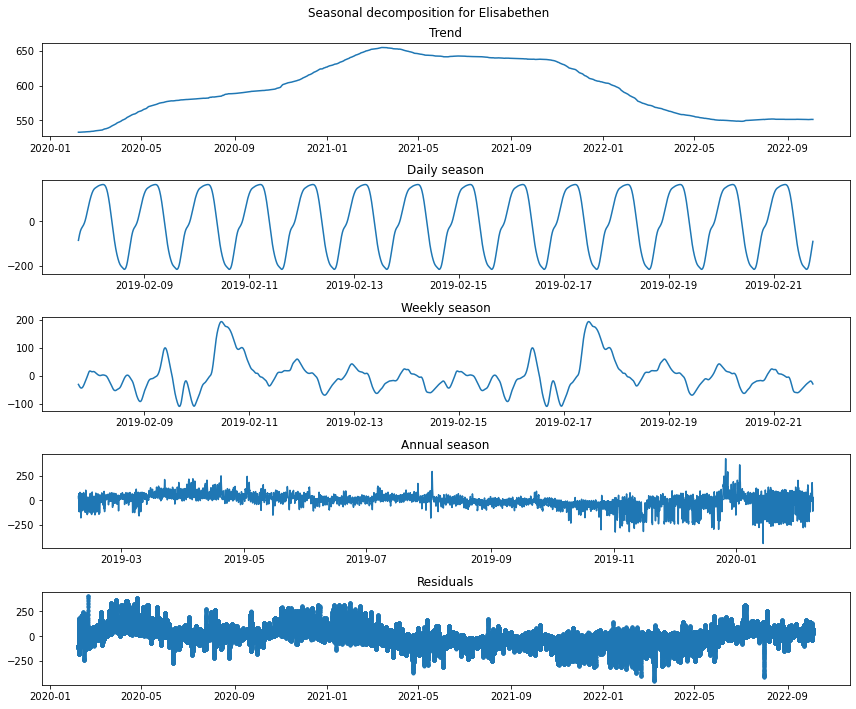

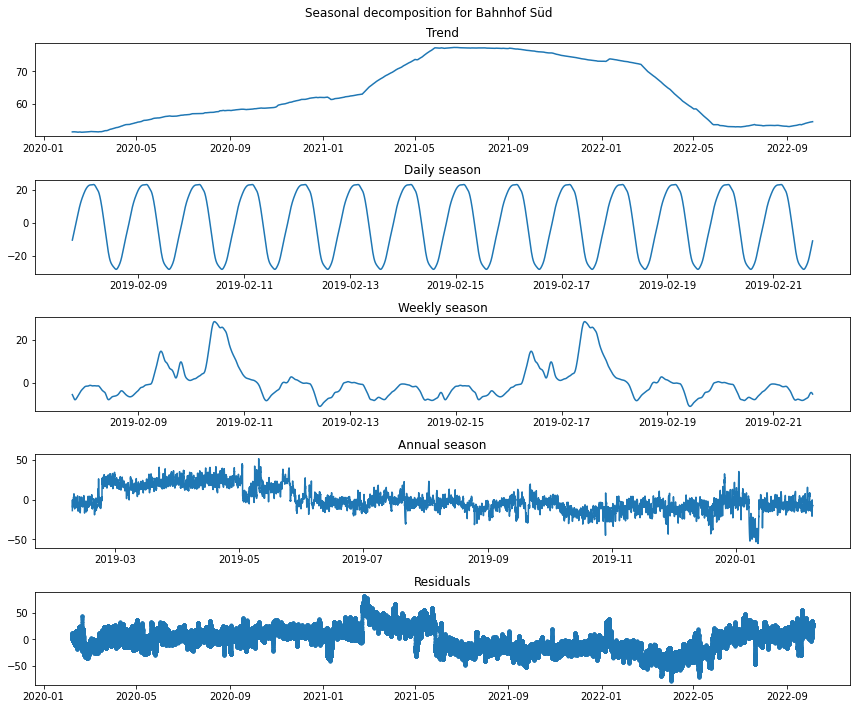

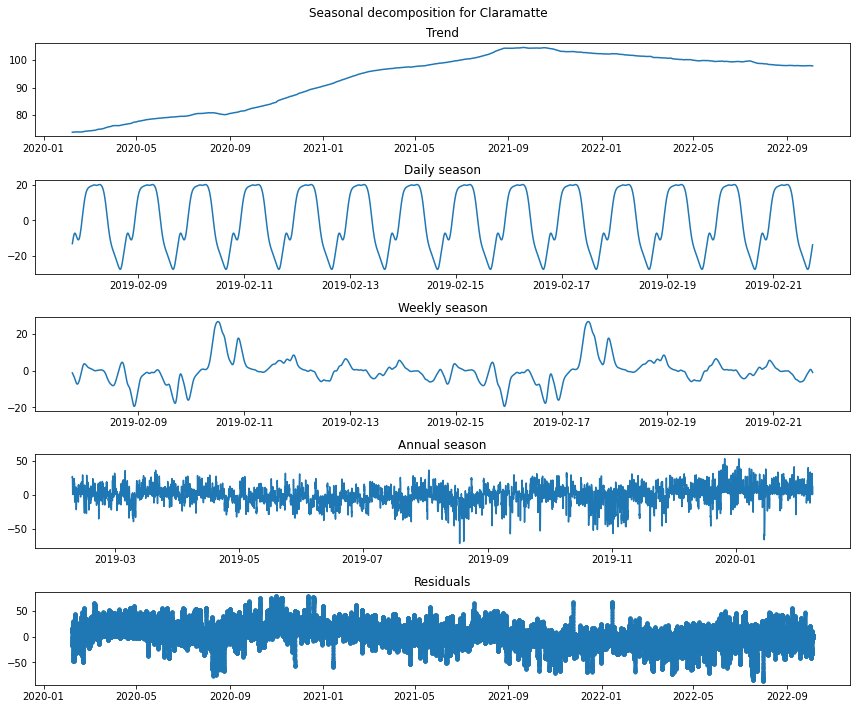

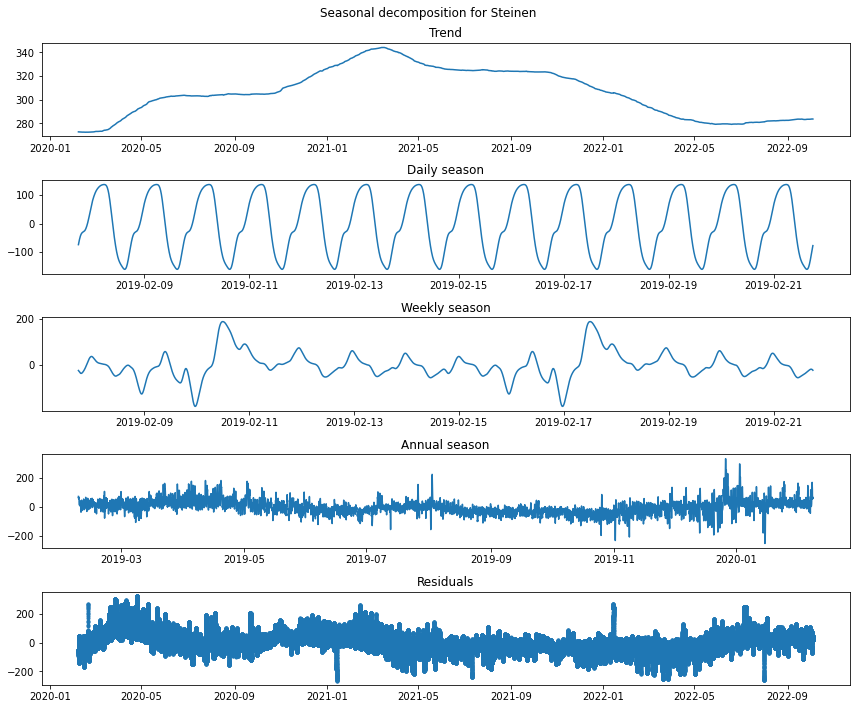

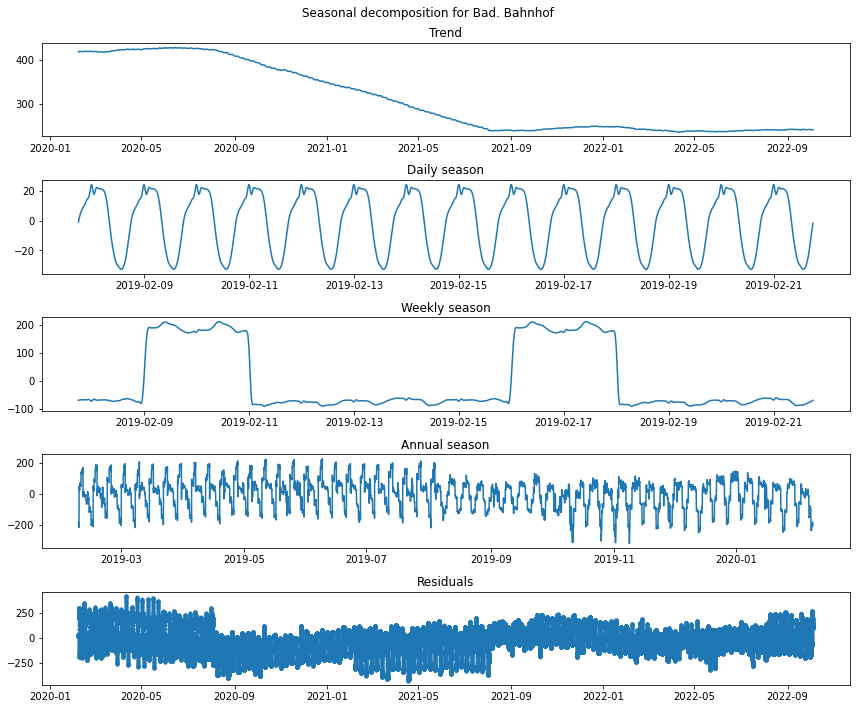

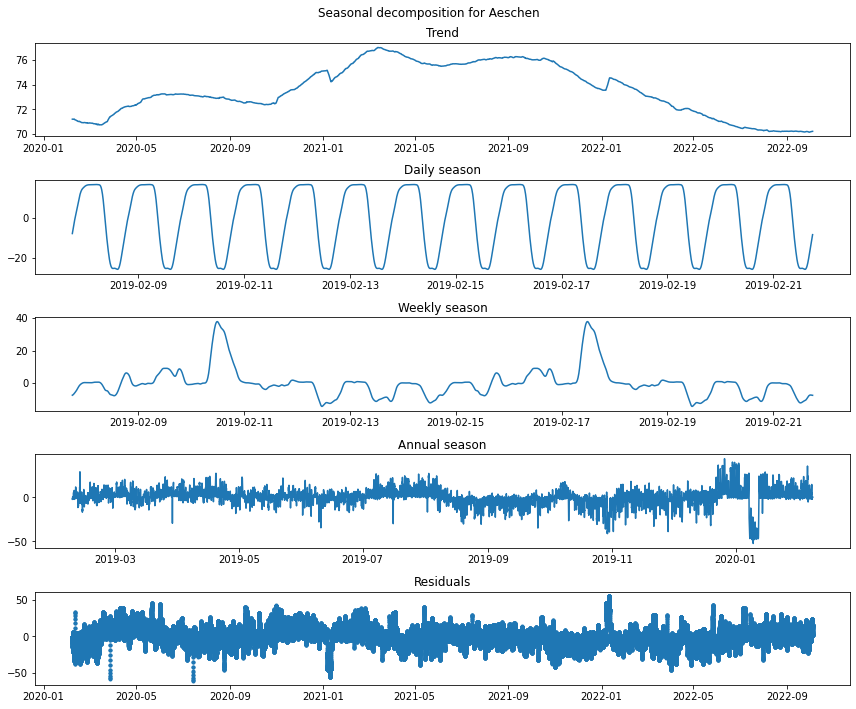

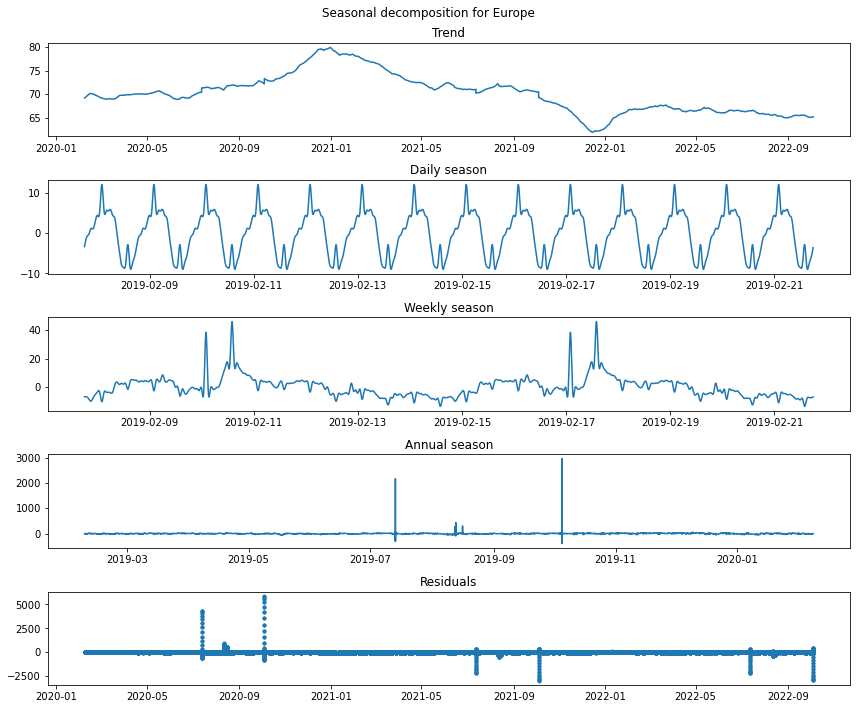

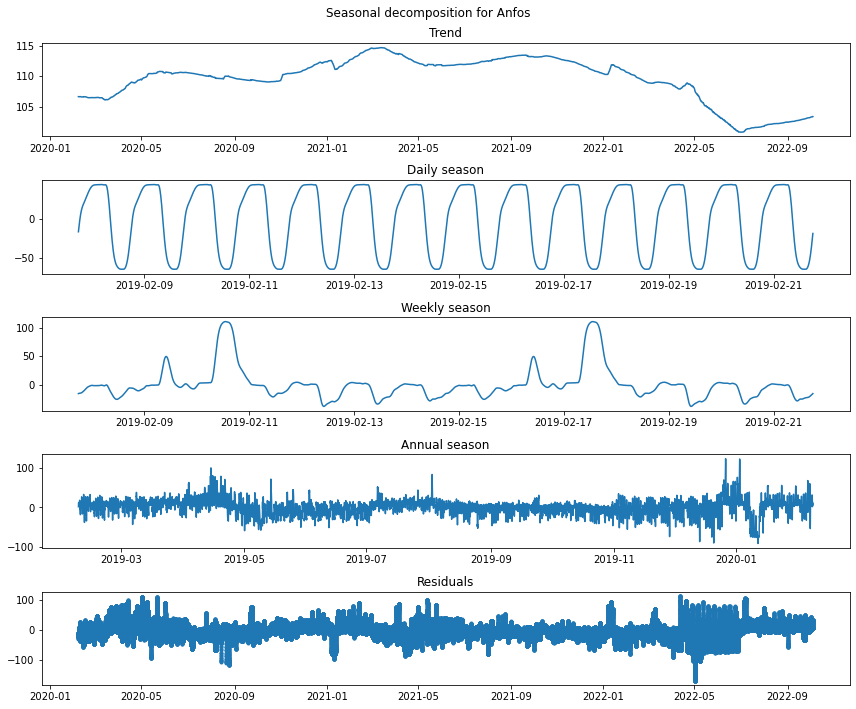

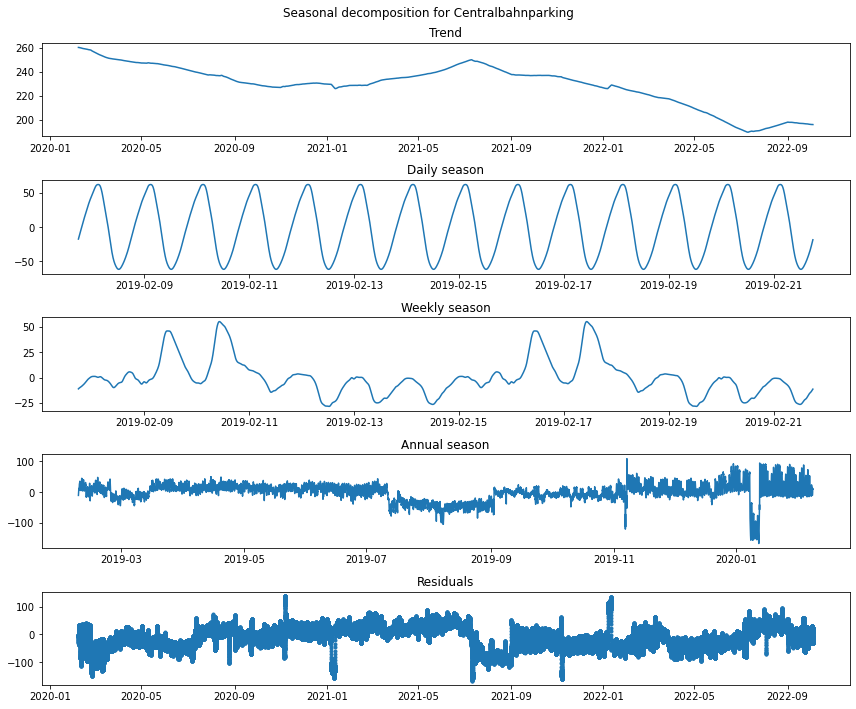

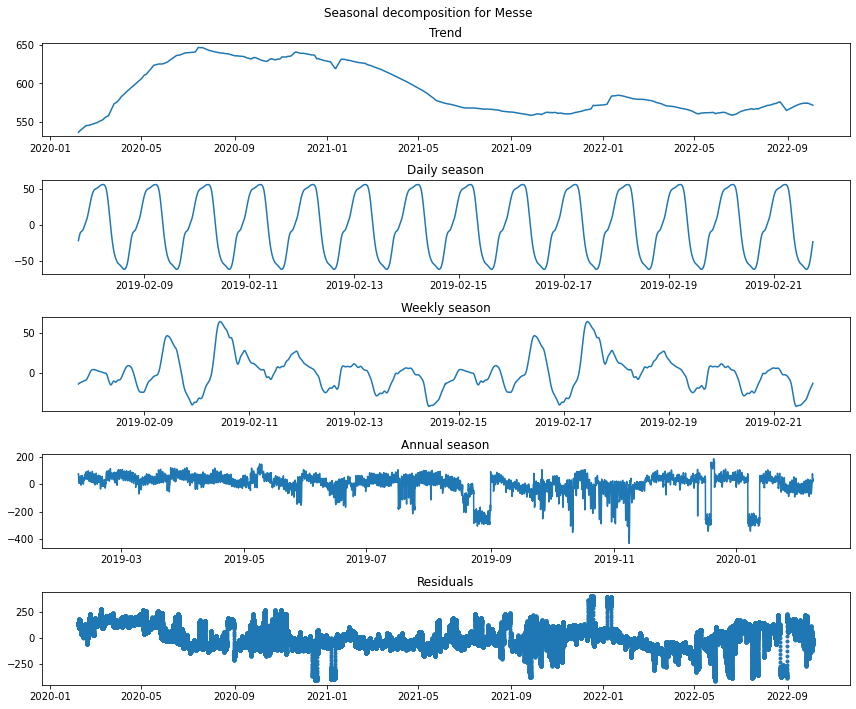

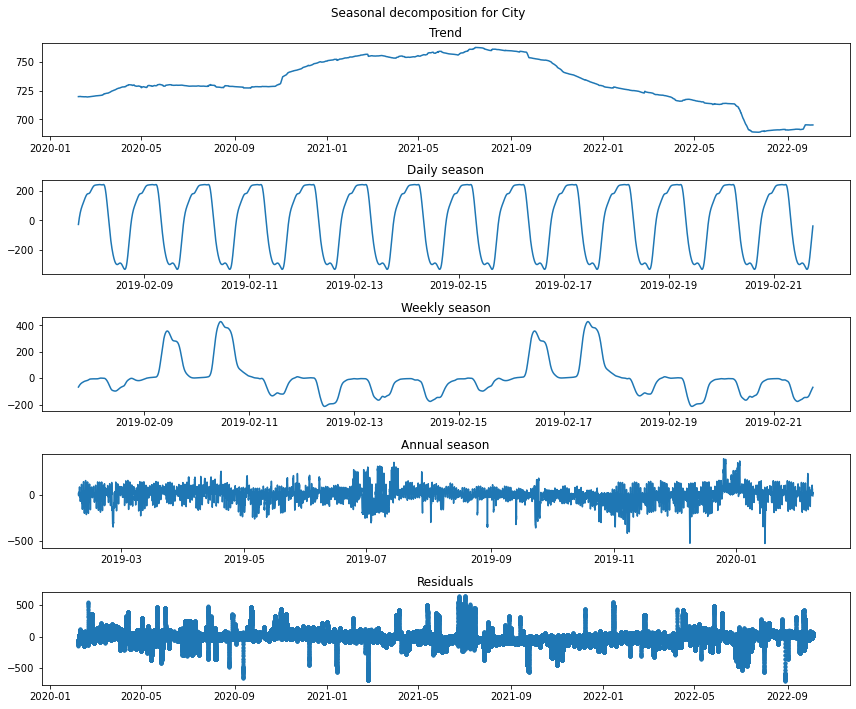

In [220]:
from sklearn import linear_model

def multiple_seasonal_decompose(df, minutes_per_sample):
    # daily season
    daily = int((24*60) / minutes_per_sample)
    d_s = seasonal_decompose(df, period=daily, model="additive", two_sided=False)
    df = df - d_s.seasonal
    # weekly season
    weekly = daily * 7
    w_s = seasonal_decompose(df, period=weekly, model="additive", two_sided=False)
    df = df - w_s.seasonal
    # weekly season
    annual = daily * 365
    a_s = seasonal_decompose(df, period=annual, model="additive", two_sided=False)
    df = df - a_s.seasonal
    
    return  a_s.resid, d_s.seasonal, w_s.seasonal, a_s.seasonal, a_s.trend

def plot_decomposition(resid, daily, weekly, annualy, trend, minutes_per_sample=5, title=None):
    x=150500
    one_day = int((24*60) / minutes_per_sample)
    fig, (ax0,ax1,ax2,ax3,ax4) = plt.subplots(5,1, figsize=(12,10))
    ax0.plot(trend)
    ax1.plot(daily[0:one_day*7*2])
    ax2.plot(weekly[0:one_day*7*2])
    ax3.plot(annualy[0:round(one_day*365.25)])
    ax4.plot(resid, ".")
    
    if title is None:
        plt.suptitle('Seasonal Decomposition')
    else:
        plt.suptitle(title)
    ax0.title.set_text('Trend')
    ax1.title.set_text('Daily season')
    ax2.title.set_text('Weekly season')
    ax3.title.set_text('Annual season')
    ax4.title.set_text('Residuals')
    fig.tight_layout()
    plt.show()
    
df_resid = pd.DataFrame(columns=['name', 'mean', 'std', 'min', 'max'])
ignore_garages=["Kunstmuseum"]    
for g in ignore_garages:
    df = df[df["name"]!=g]
for name in set(df["name"]):
    free_places = df[df["name"]==name]["free"]
    resid, daily, weekly, annualy, trend = multiple_seasonal_decompose(free_places, 5)
    plot_decomposition(resid, daily, weekly, annualy, trend, title=f"Seasonal decomposition for {name}")
    df_resid = df_resid.append({"name":name, "mean":np.mean(resid), "std":np.std(resid), "min":np.min(resid), "max":np.max(resid)}, ignore_index=True)

**Description:** The visualisation shows the trend, daily season, weekly season, annual season and the residuals of the decomposition. There is a clear daily and weekly seasonality with easily recognisable patterns. The annual seasonality, however, does not look so clear and looks more like noise. Since the annual seasonality in the decomposition was calculated on an average of two years (2 values), there is probably too much noise in the annual seasonality for it to be useful for forecasting.

The trend of free parking spaces is not quite constant, but it changes relatively slowly. Since we only want to make predictions up to a maximum of one day ahead at a time, we can assume that the trend from one day to the next remains the same for the sake of simplicity, after deducting seasonal factors.

However, it can also be seen that the residuals of the car parks are in part relatively high, which raises doubts as to whether a reliable forecast can be achieved with simple trend and seasonal extraction. In a next step, the standard deviation of the residuals is therefore examined in proportion to the total capacity of parking spots per garage.

In [221]:
df_resid = df_resid.merge(df.groupby("name").max()["total"].reset_index(), left_on="name",  right_on="name")
df_resid = df_resid.rename(columns={"total":"total_free"})

C:\Users\samlu\AppData\Local\Temp/ipykernel_25048/2577555914.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  df_resid = df_resid.merge(df.groupby("name").max()["total"].reset_index(), left_on="name",  right_on="name")


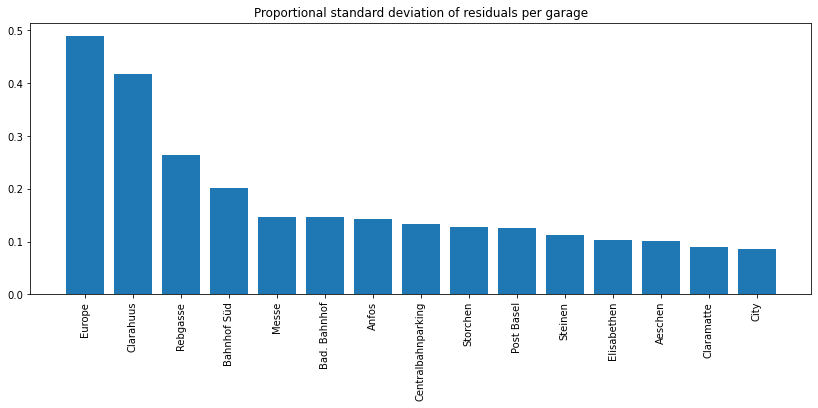

In [222]:
df_resid["std_prop"] = df_resid["std"] / df_resid["total_free"]
df_resid = df_resid.sort_values("std_prop", ascending=False)
plt.figure(figsize=(14, 5))
plt.bar(df_resid["name"], df_resid["std_prop"])
plt.title("Proportional standard deviation of residuals per garage")
plt.xticks(rotation = 90)
plt.show()

**Description:** The visualization shows the standard deviation of the residuals in proportion to the total number of parking spaces per garage. We see that the standard deviation of the residuals is on average between 10 and 20 percent of the total number of parking spaces, making a forecast based on the extracted trend and seasonalities relatively inaccurate. An extreme case is the parking garage Europe, where the standard deviation of the residuals is even close to 50% of the total number of parking spaces. It shows that in this case, no meaningful prediction would be possible.

### Conclusion: 
Because we were not able to achieve a good decomposition with small residuals, we will no further invest time to create a statistical approach on modeling. We are instead focusing on using a deep leaning approach using cnn's and rnn's.

### Store dictionary of seasonalities

In [7]:
import pickle
import json

def create_annual_lookup(season):
    '''Create lookup fpr annual seasonalities'''
    table = season.groupby([season.index.dayofyear, season.index.time]).mean().reset_index()
    table.columns = ["day_of_year", "time", "value"]
    return table

def create_weekly_lookup(season):
    '''Create lookup fpr weekly seasonalities'''
    table = season.groupby([season.index.dayofweek, season.index.time]).mean().reset_index()
    table.columns = ["day_of_week", "time", "value"]
    return table

def create_daily_lookup(season):
    '''Create lookup fpr daily seasonalities'''
    table = season.groupby(season.index.time).mean().reset_index()
    table.columns = ["time", "value"]
    return table

def create_seasonality_lookup(df, column="free", minutes_per_sample=5, file='seasonalities.pickle', ignore_garages=["Kunstmuseum"]):
    '''
    Creates a lookup table that saves the daily, weekly and annualy 
    seasonality from a defined column in df and saves it as pickle.
    '''
    for g in ignore_garages:
        df = df[df["name"]!=g]
        
    lookup = dict()
    for name in set(df["name"]):
        lookup[name] = dict()
        free_places = df[df["name"]==name][column]
        resid, daily, weekly, annualy, trend = multiple_seasonal_decompose(free_places, minutes_per_sample)

        lookup[name]["annualy"] = create_annual_lookup(annualy).to_json()
        lookup[name]["weekly"] = create_weekly_lookup(weekly).to_json()
        lookup[name]["daily"] = create_daily_lookup(daily).to_json()
        
    with open(file, 'wb') as f:
        pickle.dump(lookup, f)
        
create_seasonality_lookup(df)

In [148]:
import os


def round_dt(dt, delta):
    '''
    Rounds a timestamo to the next time-delta
    Args:
        dt: datetime
        delta: timedelta
    Returns:
        rounded datetime
    '''
    return datetime.min + math.ceil((dt - datetime.min) / delta) * delta




def construct_seasonalities(name, steps, file='seasonalities.pickle', round_minutes=5):
    '''
    Constructs the seasonalities for a specified time period
    Args:
        name: name of the car garage
        steps: list of datetimes
        file: name of the save file
        round_minutes: minutes per measuring point
        
    '''
    
    if os.path.exists(file):
        with open(file, 'rb') as f:
            lookup = pickle.load(f)

    daily = pd.DataFrame.from_dict(json.loads(lookup[name]["daily"]))
    weekly = pd.DataFrame.from_dict(json.loads(lookup[name]["weekly"]))
    annualy = pd.DataFrame.from_dict(json.loads(lookup[name]["annualy"]))
    
    daily_season = []
    weekly_season = []
    annual_season = []
    
    delta = timedelta(minutes=round_minutes)
    
    for step in steps:
        tm = round_dt(step, delta).strftime('%H:%M:%S')
        dw = step.weekday()
        dy = step.timetuple().tm_yday

        daily_season.append((daily.loc[daily["time"]==tm]).reset_index(drop=True).at[0, "value"])
        weekly_season.append((weekly.loc[(weekly["time"]==tm) & (weekly["day_of_week"]==dw)]).reset_index(drop=True).at[0, "value"])
        annual_season.append((annualy.loc[(annualy["time"]==tm) & (annualy["day_of_year"]==dy)]).reset_index(drop=True).at[0, "value"])
    df_seasons = pd.DataFrame({"datetime":[round_dt(step, delta) for step in steps], 
                               "daily_season":daily_season, 
                               "weekly_season":weekly_season, 
                               "annual_season":annual_season})
    return df_seasons
      
    

steps = [datetime.now() - timedelta(minutes = i * 5) for i in range(12)]
construct_seasonalities(name="Steinen", steps=steps)

,timestamp,daily_season,weekly_season,annual_season
0,2022-12-29 13:05:00,-139.263044,-43.577289,38.569677
1,2022-12-29 13:00:00,-137.990090,-44.057640,41.440328
2,2022-12-29 12:55:00,-136.664818,-44.546232,44.507902
3,2022-12-29 12:50:00,-135.280497,-45.042488,47.755925
4,2022-12-29 12:45:00,-133.829934,-45.545268,51.159830
5,2022-12-29 12:40:00,-132.305937,-46.053430,54.695049
6,2022-12-29 12:35:00,-130.701312,-46.565835,58.337014
7,2022-12-29 12:30:00,-129.008865,-47.081343,62.061160
8,2022-12-29 12:25:00,-127.221403,-47.598815,65.842918
9,2022-12-29 12:20:00,-125.331731,-48.117110,69.657720


In [ ]:
pd.read_csv()

[[datetime.datetime(2022, 10, 4, 14, 0)]
 [datetime.datetime(2022, 10, 4, 19, 0)]]


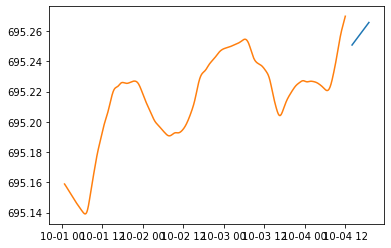

In [96]:
from sklearn.linear_model import LinearRegression
def predict_linear_trend(trend, predict_minutes=5, include_min=720):
    "calculates an ols linear trend"
   
    trend = trend.dropna()
    trend = trend[trend.index > max(trend.index) - timedelta(minutes=include_min)]
    
    dtm = trend.index
    X = np.array(trend.index.view(np.int64) // 10**9).reshape(-1, 1)
    y = trend.values.reshape(-1, 1)

    reg = LinearRegression().fit(X, y)
    prediction_time = datetime.timestamp(max(trend.index) + timedelta(minutes=predict_minutes))
    last_time = datetime.timestamp(max(trend.index))
    X_pred = np.array([last_time, prediction_time]).reshape(-1,1)
    dtm = np.array([datetime.fromtimestamp(i) for i in [last_time, prediction_time]]).reshape(-1, 1)
    return dtm, reg.predict(X_pred)

X_pred, y_pred = predict_linear_trend(trend, 300)
print(X_pred)

fig, ax = plt.subplots()

plt.plot(X_pred, y_pred)

plt.plot(trend.index[-1000:], trend.values[-1000:])
plt.show()

published
2019-02-07 18:00:00+00:00    59.000000
2019-02-07 18:05:00+00:00    58.663226
2019-02-07 18:10:00+00:00    58.461408
2019-02-07 18:15:00+00:00    58.386064
2019-02-07 18:20:00+00:00    58.428714
                               ...    
2022-10-04 11:40:00+00:00    39.756603
2022-10-04 11:45:00+00:00    40.339053
2022-10-04 11:50:00+00:00    41.228498
2022-10-04 11:55:00+00:00    42.442845
2022-10-04 12:00:00+00:00    44.000000
Name: free, Length: 384409, dtype: float64


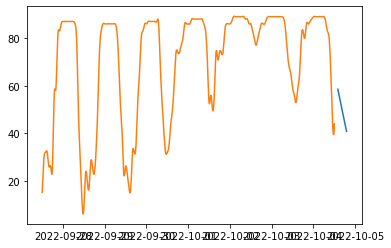

In [135]:
d = df[df["name"]=="Aeschen"]["free"].rolling(12*24*365).mean()
print(d)
X_pred, y_pred = predict_linear_trend(d, 300, 720)


fig, ax = plt.subplots()

plt.plot(X_pred, y_pred)

plt.plot(d.index[-12*24*7:], d.values[-12*24*7:])
plt.show()

In [142]:
i = 12*24*9
df[df["name"]=="Aeschen"]["free"][0+i:12*24*7+i].mean()

73.0939189801262

weekly
2016
288


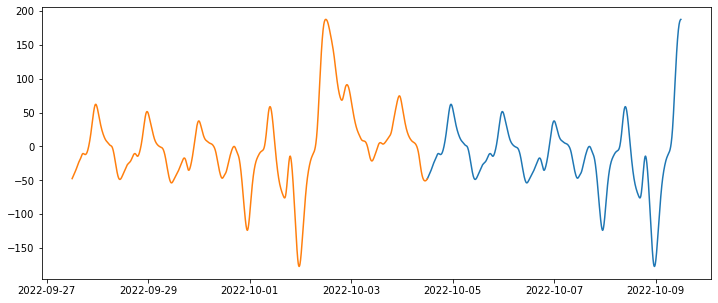

In [474]:
import math
def predict_season(season, predict_minutes=5, minutes_per_sample=5 ):
    season = season.dropna()
    
    daily = int((24*60) / minutes_per_sample)
    weekly = daily * 7
    annualy = daily * 365
    
    daily_season = season.shift(daily).dropna()
    weekly_season = season.shift(weekly).dropna()
    annual_season = season.shift(annualy).dropna()
    
    if daily_season.tolist()[-daily:] == season[-daily:].tolist():
        print("daily")
        step = daily
        
    elif weekly_season.tolist()[-daily:] == season.tolist()[-daily:]:
        print("weekly")
        step = weekly
    elif annual_season.tolist()[-daily:] == season.tolist()[-daily:]:
        print("annualy")
        step = annualy
    print(step)
        
    n_predictions = math.ceil(predict_minutes / minutes_per_sample)
    print(n_predictions)
    
    
    predictions = season[-(1+step):-(1+step)+n_predictions * minutes_per_sample]
    predictions.index = predictions.index + timedelta(minutes = (step * minutes_per_sample))
    
    return predictions
    

test = predict_season(weekly, predict_minutes=12*24*5)

fig, ax = plt.subplots(figsize=(12,5))
plt.plot(test)
plt.plot(weekly[-12*24*7:])
plt.show()
